In [51]:
import cv2
import glob
import numpy as np
import pandas as pd

import timm 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader

from collections import Counter
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

flist = glob.glob("data/whole_patches_in_pos_WSI_2048_only_labeled/*.png")

df = []
for f in flist:
    f_split = f.split("/")[-1].split("_")
    label = [1 if f_split[0] == "pos" else 0][0]
    p_id = f_split[1]
    s_id = f_split[2]

    df.append([p_id, s_id, label, f])

df = pd.DataFrame(df, columns=["p_id", "s_id", "label", "fpath"])

In [52]:
project_name = "resnet18_100%"
aug_flist = glob.glob(f"results/aug-data_{project_name}/*.jpg")

aug_df = []
for aug_f in aug_flist:
    p_id = aug_f.split("/")[-1].split("_")[0]
    s_id = aug_f.split("/")[-1].split("_")[2]
    label = 2
    aug_df.append([p_id, s_id, label, aug_f])
    
aug_df = pd.DataFrame(aug_df, columns=["p_id", "s_id", "label", "fpath"])

df = df.append(aug_df).reset_index(drop=True)
df.label = df.label.astype(np.uint8)

# def assign_labels(x):
#     if x == 0:
#         return "Normal"
#     elif x == 1:
#         return "LI"
#     elif x == 2:
#         return "False Negative"


# df.label = df.label.map(assign_labels)

In [53]:
weak_model = timm.create_model("resnet18", pretrained=False, num_classes=2)
weak_model.load_state_dict(torch.load("weights/resnet18_100%_weak-model/weak_model.pt"))
weak_model = weak_model.to("cuda:0")
weak_model.eval()

strong_model = timm.create_model("resnet18", pretrained=False, num_classes=2)
strong_model.load_state_dict(torch.load("weights/resnet18_100%_strong-model/strong_model.pt"))
strong_model = strong_model.to("cuda:0")
strong_model.eval()

valid_transforms = A.Compose([ 
    A.Resize(width=224, height=224, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2()
])

class PatchDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
           
    def __len__(self):    
        return len(self.df)
    
    def __getitem__(self, idx):
        x = cv2.imread(self.df.loc[idx, "fpath"])
        x = self.transform(image=x)['image']
        
        y = self.df.loc[idx, "label"]
                
        return x, torch.tensor(y).long()
    
dataset = PatchDataset(df, valid_transforms)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False,
                        pin_memory=True, num_workers=32)

/home/user/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [54]:
from sklearn.manifold import TSNE

weak_feats = torch.tensor([])
strong_feats = torch.tensor([])

for i, batch in enumerate(dataloader):
    x, y = batch
    x = x.to("cuda:0")
    
    weak_feat = weak_model.forward_features(x)
    weak_feat = torch.mean(weak_feat.view(weak_feat.size(0), weak_feat.size(1), -1), dim=2)
    weak_feat = weak_feat.detach().to('cpu')
    
    weak_feats = torch.cat((weak_feats, weak_feat), dim=0)
    
    strong_feat = strong_model.forward_features(x)
    strong_feat = torch.mean(strong_feat.view(strong_feat.size(0), strong_feat.size(1), -1), dim=2)
    strong_feat = strong_feat.detach().to('cpu')
    
    strong_feats = torch.cat((strong_feats, strong_feat), dim=0)

In [55]:
tsne_weak = TSNE(n_components=2, perplexity=5, n_iter=1000).fit_transform(weak_feats.numpy())
tsne_strong = TSNE(n_components=2, perplexity=5, n_iter=1000).fit_transform(strong_feats.numpy())

/home/user/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/user/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/user/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/user/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [74]:
tsne_weak_df = pd.DataFrame(tsne_weak, columns=[0, 1])
tsne_weak_df.loc[:, "label"] = df.label

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [73]:
tsne_weak.shape

(1227, 2)

In [75]:
tsne_weak[(df.label==1).values.tolist(), :]

array([], shape=(0, 2), dtype=float32)

In [62]:
tsne_weak[(df.label==1).values.t]

AttributeError: 'numpy.ndarray' object has no attribute 't'

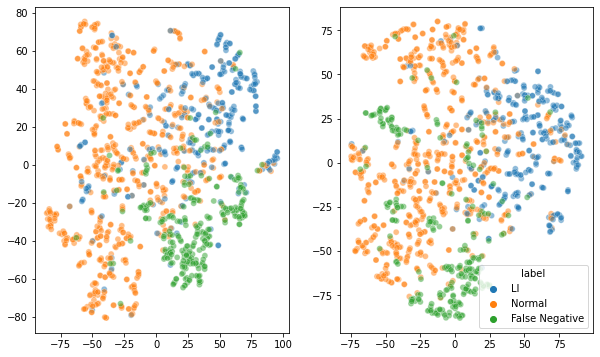

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_weak[:, 0], y=tsne_weak[:, 1], hue=df.label, legend=False, alpha=0.5)

plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_strong[:, 0], y=tsne_strong[:, 1], hue=df.label, alpha=0.5)

plt.show()